## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set()

## Importing and preprocessing the data

In [4]:
# First, we import the raw data into the raw_data object which contains information that we will not
# be needing in our further analysis. Note that these data are publicly available on https://www.endu.net/en/events/padovamarathon/results.
# Worth noting is that, a manual search was performed on Strava based on the names of the participants to extract some of their performance
# indices to be included in the regression analysis. These names were searched "randomly" with an effort to cover most of the 
# "common" finish times.

#changin the directory to the main half-marathon project folder
import os
os.chdir('C:\\Users\\hadip\\Downloads\\Portfolio\\half_marathon')

raw_data = pd.read_excel('data\\first_padovahm.xls')
raw_data.head()

,POS_ASSOLUTA,PETTORALE,COGNOME,NOME,SESSO,ANNO,TEAM,NAZIONALITA,CATEGORIA,POS_CAT,...,TEMPO_UFFICIALE,TEMPO_REALE,DISTACCO,AVG HR,2025 km,Total km,5K PB min,5K PB sec,10K PB min,10K PB sec
0,2211,8043,PONCHIA,ANNA GIULIA,F,1997,RUNCARD,ita,SF,169,...,02:12:54,02:07:44,+1:10:16,NaN,40.0,354.0,28.0,43.0,58.0,58.0
1,2491,8925,BUONAGURA,DAVIDE,M,1986,RUN CARD,ita,SM35,252,...,02:20:56,02:16:03,+1:18:18,NaN,41.0,103.0,26.0,38.0,55.0,2.0
2,781,8883,DILEO,ANDREA,M,1993,RUN CARD,ita,SM,252,...,01:46:33,01:41:20,+43:55,173.0,44.0,320.0,21.0,39.0,45.0,53.0
3,2181,8549,MENGA,FRANCESCO GIUSEPPE,M,2001,RUNCARD,ita,SM,548,...,02:12:21,02:07:33,+1:09:43,NaN,109.0,109.0,27.0,29.0,58.0,28.0
4,1507,7415,ZIN,DANIEL,M,1995,RUNCARD,ita,SM,424,...,01:58:52,01:56:24,+56:14,163.0,133.0,163.0,24.0,35.0,52.0,44.0


In [5]:
# Here we drop the name, sirname, and other columns that will not be used neither as regressors nor in the descriptive analysis of the whole data.
# by "data_whole", it is meant that this contains the data regarding the performance of all the participants, naturally without their
# background data such as their mileage or personal records in 5K, etc.

# The information that was extracted from participants' Strava accounts included: Total mileage, 2025 mileage, 5K personal best, 10K personal best,
# and average heart rate during the race (if available). 

data_whole = raw_data.drop(['POS_ASSOLUTA','NOME','COGNOME', 'DISTACCO', 'TEAM', 'CATEGORIA', 'POS_CAT', 'POS_SESSO', 'TEMPO_UFFICIALE'], axis = 1)
data_whole.head()

,PETTORALE,SESSO,ANNO,NAZIONALITA,TEMPO_REALE,AVG HR,2025 km,Total km,5K PB min,5K PB sec,10K PB min,10K PB sec
0,8043,F,1997,ita,02:07:44,NaN,40.0,354.0,28.0,43.0,58.0,58.0
1,8925,M,1986,ita,02:16:03,NaN,41.0,103.0,26.0,38.0,55.0,2.0
2,8883,M,1993,ita,01:41:20,173.0,44.0,320.0,21.0,39.0,45.0,53.0
3,8549,M,2001,ita,02:07:33,NaN,109.0,109.0,27.0,29.0,58.0,28.0
4,7415,M,1995,ita,01:56:24,163.0,133.0,163.0,24.0,35.0,52.0,44.0


In [6]:
# Considering that the original values of the 5K and 10K personal best records were registered in separate columns in the excel file representing the
# minutes and seconds of those records respectively, the minute column will be transformed to seconds and added to the seconds.


data_whole['5K_PB'] = data_whole['5K PB min'] * 60 + data_whole['5K PB sec']
data_whole['10K_PB'] = data_whole['10K PB min'] * 60 + data_whole['10K PB sec']


data_whole = data_whole.drop(['5K PB min', '5K PB sec', '10K PB min', '10K PB sec'], axis = 1)

In [7]:
# considering that the finish time in the original dataset are imported as strings
# we would want to transform them to the pandas timedelta format and then into seconds for further analysis.

data_whole['TEMPO_REALE_timedelta'] = pd.to_timedelta(data_whole['TEMPO_REALE'])
data_whole['TEMPO_REALE_SECONDS'] = data_whole['TEMPO_REALE_timedelta'].dt.total_seconds()
data_whole['Finish_time_minutes'] = data_whole['TEMPO_REALE_SECONDS']/60
data_whole=data_whole.drop(['TEMPO_REALE'], axis = 1)

### Descriptive analysis on the whole data

In [9]:
data_whole.describe(include='all')

,PETTORALE,SESSO,ANNO,NAZIONALITA,AVG HR,2025 km,Total km,5K_PB,10K_PB,TEMPO_REALE_timedelta,TEMPO_REALE_SECONDS,Finish_time_minutes
count,2887.000000,2887,2887.000000,2887,87.000000,123.000000,123.000000,123.000000,123.000000,2887,2887.000000,2887.000000
unique,NaN,2,NaN,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M,NaN,ita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2061,NaN,2786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7388.570835,NaN,1983.453412,NaN,168.471264,647.658537,4446.325203,1323.788618,2819.113821,0 days 01:56:57.304121925,7017.304122,116.955069
std,1364.142722,NaN,12.323592,NaN,11.183292,448.692980,6808.348335,238.907083,516.446500,0 days 00:19:42.594922557,1182.594923,19.709915
min,460.000000,NaN,1944.000000,NaN,140.000000,40.000000,103.000000,756.000000,1579.000000,0 days 01:02:38,3758.000000,62.633333
25%,5994.500000,NaN,1974.000000,NaN,159.500000,314.000000,714.000000,1126.000000,2358.000000,0 days 01:43:42.500000,6222.500000,103.708333
50%,7644.000000,NaN,1984.000000,NaN,170.000000,557.000000,2034.000000,1358.000000,2904.000000,0 days 01:55:14,6914.000000,115.233333
75%,8551.500000,NaN,1994.000000,NaN,176.000000,901.500000,5116.000000,1523.000000,3241.000000,0 days 02:08:28,7708.000000,128.466667


In [10]:
# In total, 2887 people participated in the race, 2061 of which were men (71.38 %). The average year of birth was 1983, making 42 as the average
# age of the participants in the 2025 edition of the race. On average, participants finished the half-marathon in almost 1 hour and 57 minutes with 
# 75% of them finishing the race in less than 2 hours, 8 minutes. 
# 46 different nationalities were present in the race with Italy having the highest presence (96.5 %).

In [11]:
pd.set_option('display.max_rows', None)
data_whole.groupby('SESSO').describe().transpose()

SESSO                                                F  \
PETTORALE             count                      826.0   
                      mean                 7890.146489   
                      std                  1122.386188   
                      min                       2394.0   
                      25%                      7265.25   
                      50%                       8183.5   
                      75%                      8754.75   
                      max                       9431.0   
ANNO                  count                      826.0   
                      mean                 1984.184019   
                      std                    12.206607   
                      min                       1952.0   
                      25%                       1974.0   
                      50%                       1984.0   
                      75%                       1995.0   
                      max                       2007.0   
AVG HR                count                       33.0   
                      mean                  170.515152   
                      std                     9.121133   
                      min                        150.0   
                      25%                        164.0   
                      50%                        173.0   
                      75%                        176.0   
                      max                        185.0   
2025 km               count                       49.0   
                      mean                  612.040816   
                      std                   368.226094   
                      min                         40.0   
                      25%                        370.0   
                      50%                        557.0   
                      75%                        743.0   
                      max                       1986.0   
Total km              count                       49.0   
                      mean                 4204.795918   
                      std                  6109.116473   
                      min                        292.0   
                      25%                        916.0   
                      50%                       1825.0   
                      75%                       4373.0   
                      max                      31081.0   
5K_PB                 count                       49.0   
                      mean                  1369.55102   
                      std                   213.261289   
                      min                        756.0   
                      25%                       1254.0   
                      50%                       1403.0   
                      75%                       1520.0   
                      max                       1741.0   
10K_PB                count                       49.0   
                      mean                  2969.77551   
                      std                   416.248036   
                      min                       1579.0   
                      25%                       2744.0   
                      50%                       3005.0   
                      75%                       3278.0   
                      max                       3710.0   
TEMPO_REALE_timedelta count                        826   
                      mean   0 days 02:07:35.430992736   
                      std    0 days 00:18:56.726140397   
                      min              0 days 01:11:27   
                      25%              0 days 01:54:48   
                      50%       0 days 02:05:31.500000   
                      75%       0 days 02:18:40.750000   
                      max              0 days 03:27:43   
TEMPO_REALE_SECONDS   count                      826.0   
                      mean                 7655.430993   
                      std                   1136.72614   
                      min                       4287.0  

In [12]:
# Looking at males and females, on average, males finished the race in almost 1 hour and 53 minutes with half of them finishing in less than
# 1 hour and 51 minutes. Instead, females on average finished the half-marathon race in 2 hours and 8 minutes with half of them finishing
# in less than 2 hours and 6 minutes.

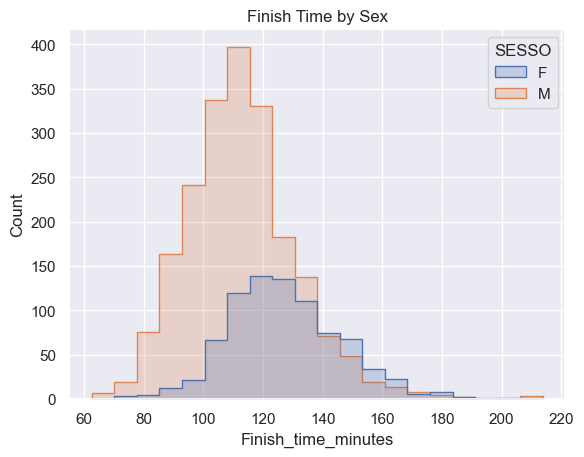

In [13]:
sns.histplot(data=data_whole, x='Finish_time_minutes', hue='SESSO', bins=20, element='step', common_norm=False)
plt.title('Finish Time by Sex')
plt.show()

## Regression Analysis

In [15]:
# Considering that the average heart rate during the race was not available for all the particpants, . This is done because all the performance 
# metrics are available for all the samples except for HR, so there are
# some participants for which the 2025 km is available but HR during the race isn't, thus the discrepency. 


# we first set "PETTORALE" as the index to be later used  as the binding index between the two sets of dataframes
reg_data_init = data_whole.set_index('PETTORALE')

# then save the AVG HR in a new object
reg_data_HR = reg_data_init['AVG HR']

# then drop the AVG HR column from the initial and original dataframe
reg_data = reg_data_init.drop(['AVG HR'], axis = 1)

# then drop the missing values from the dataframe, which will be the majority of the rows, since the information gathered manually
# on Strava included only 123 individuals. If we had done this on the dataframe including the AVG HR, we would have omitted the
# rows with a missing value on AVG HR, which was not ok since some individuals did not have AVG HR but had other info.
reg_data = reg_data.dropna(axis = 0)

# we will now add the column containing AVG HR to the new dataframe containing no missing values. Since the index was 
# set to be the 'PETTORALE' the AVG HR would be assigned correctly. 
reg_data ['AVG_HR'] =  reg_data_HR

# We will reset the index and visualize the dataframe.
reg_data.reset_index(inplace=True)
reg_data.head()

,PETTORALE,SESSO,ANNO,NAZIONALITA,2025 km,Total km,5K_PB,10K_PB,TEMPO_REALE_timedelta,TEMPO_REALE_SECONDS,Finish_time_minutes,AVG_HR
0,8043,F,1997,ita,40.0,354.0,1723.0,3538.0,0 days 02:07:44,7664.0,127.733333,NaN
1,8925,M,1986,ita,41.0,103.0,1598.0,3302.0,0 days 02:16:03,8163.0,136.050000,NaN
2,8883,M,1993,ita,44.0,320.0,1299.0,2753.0,0 days 01:41:20,6080.0,101.333333,173.0
3,8549,M,2001,ita,109.0,109.0,1649.0,3508.0,0 days 02:07:33,7653.0,127.550000,NaN
4,7415,M,1995,ita,133.0,163.0,1475.0,3164.0,0 days 01:56:24,6984.0,116.400000,163.0


In [16]:
# We will drop the variables of no interest for the regression analysis.

reg_data_final = reg_data.drop(['PETTORALE', 'NAZIONALITA', 'TEMPO_REALE_timedelta', 'Finish_time_minutes', 'AVG_HR'], axis = 1)

In [17]:
reg_data_final.describe(include='all')

,SESSO,ANNO,2025 km,Total km,5K_PB,10K_PB,TEMPO_REALE_SECONDS
count,123,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN
freq,74,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1987.642276,647.658537,4446.325203,1323.788618,2819.113821,6570.691057
std,NaN,10.589300,448.692980,6808.348335,238.907083,516.446500,1212.782995
min,NaN,1964.000000,40.000000,103.000000,756.000000,1579.000000,3955.000000
25%,NaN,1980.000000,314.000000,714.000000,1126.000000,2358.000000,5522.000000
50%,NaN,1989.000000,557.000000,2034.000000,1358.000000,2904.000000,6774.000000
75%,NaN,1997.000000,901.500000,5116.000000,1523.000000,3241.000000,7742.000000


In [18]:
# Let's look at the correlation table of the regressors except for the categorical sex.

reg_data_final.drop(['SESSO'], axis=1).corr()

,ANNO,2025 km,Total km,5K_PB,10K_PB,TEMPO_REALE_SECONDS
ANNO,1.000000,-0.098233,-0.136267,-0.061324,-0.070126,-0.166165
2025 km,-0.098233,1.000000,0.551674,-0.667659,-0.720985,-0.715933
Total km,-0.136267,0.551674,1.000000,-0.501448,-0.530829,-0.444716
5K_PB,-0.061324,-0.667659,-0.501448,1.000000,0.882658,0.817249
10K_PB,-0.070126,-0.720985,-0.530829,0.882658,1.000000,0.921630
TEMPO_REALE_SECONDS,-0.166165,-0.715933,-0.444716,0.817249,0.921630,1.000000


In [19]:
# looking at the correlation table, some interesting observations would be: 
# - Very small correlation between age and 5K, 10K, and even half-marathon finish times. 

# - Runners who ran more during the last 4 months of race in 2025 (note that race-day was on 27th April) had better 5K and 10K, and  
# half-marathon finish times. Which can make sense, since these are runners who show more stamina, greater recovery, and maybe
# more motivation because they can cover more distance in a shorter time (4 months prior to the race).

# - Total mileage in their running career (registered on Strava) was less correlated with 5K, 10K, and HF finish times. Emphasizing the 
# importance of  being active in the months before the race.

# - The better your 5K performance, the better your HM finish times, and this of course is even more pronounced in 10K times.

# - Biggest correlation among any variable with HM finish time was between 10K personal best times and HM finish times.

In [20]:
# Reordering the columns and putting the dependent variable (TEMPO_REALE_SECONDS) as the first column.

reg_data_final.columns

Index(['SESSO', 'ANNO', '2025 km', 'Total km ', '5K_PB', '10K_PB',
       'TEMPO_REALE_SECONDS'],
      dtype='object')

In [21]:
cols=['TEMPO_REALE_SECONDS','SESSO', 'ANNO', '2025 km', 'Total km ',
       '5K_PB', '10K_PB']
reg_data_final = reg_data_final[cols]

# minor changes in column names
reg_data_final = reg_data_final.rename(columns={'2025 km':'2025_km', 'Total km ':'Total_km'})

### Exploring the Pobability Density Functions

In [23]:
# At this point, we will be looking at the distribution of all the regressors and the dependent variable to then check and relax the 
# assumptions of the linear regression analysis, if needed. 

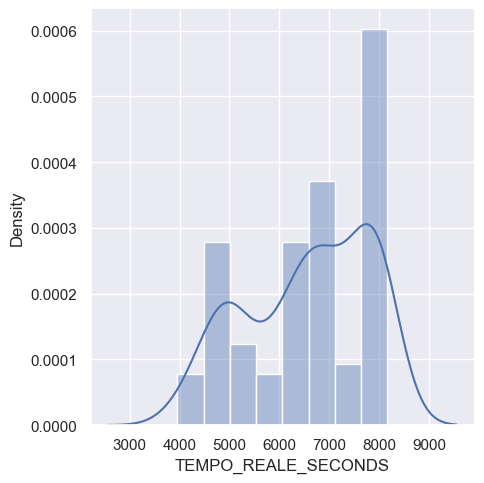

In [24]:
# Plotting the PDF of the real finish time

sns.displot(reg_data_final['TEMPO_REALE_SECONDS'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.show()

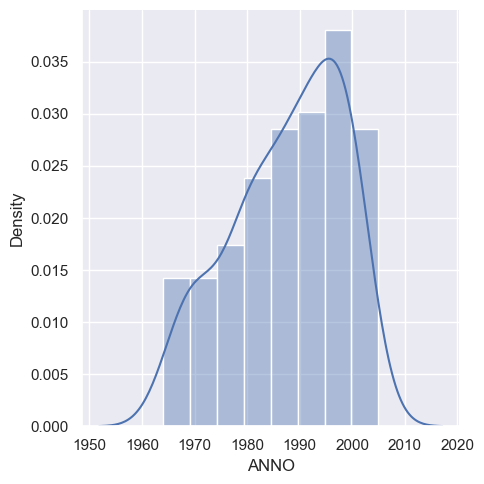

In [25]:
# Plotting the PDF of birth dates of the race participants 

sns.displot(reg_data_final['ANNO'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.show()

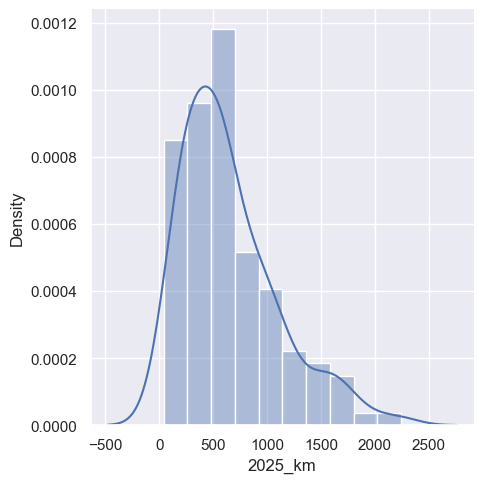

In [26]:
# Plotting the PDF of the mileage covered in 2025 up untill the race day, i.e., the 4 month period before the race.

sns.displot(reg_data_final['2025_km'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.show()

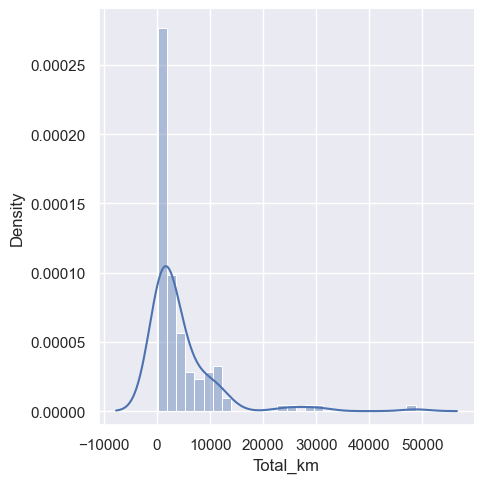

In [27]:
# PDF of the total km covered in their running career.

sns.displot(reg_data_final['Total_km'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.ylim(-0.00001)
plt.show()

In [28]:
# considering the far right tail of the distribution, we would omit the observations with total kms of higher than the 
# 95th percentile, thus removing the top 5 percent of observations. These would be individuals with extremely high mileage
# during their running career.

q = reg_data_final['Total_km'].quantile(0.95)
reg_data_no_outlier = reg_data_final[reg_data_final['Total_km']<q]

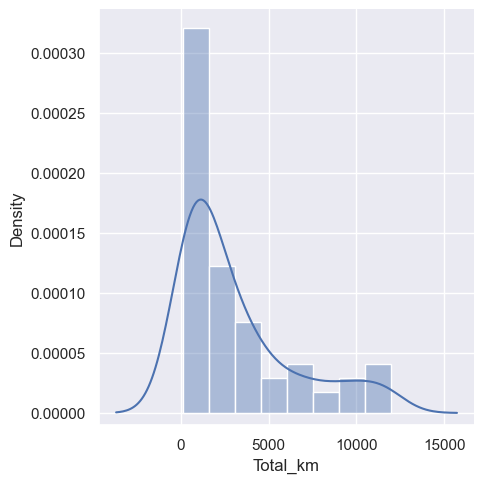

In [29]:
# Looking at the PDF of the total km after the removal of the highest 5 percent. 

sns.displot(reg_data_no_outlier['Total_km'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.ylim(-0.00001)
plt.show()

In [30]:
# considering the somewhat exponential distribution of the total km, let's transform it with a log transformation
# and also look at its scatter plot with the finish time as well as its new distribtion(histogram). 
reg_data_no_outlier = reg_data_no_outlier.copy()
# Then we add it to our data frame
reg_data_no_outlier.loc[:,'log_total_km'] = np.log(reg_data_no_outlier['Total_km'])

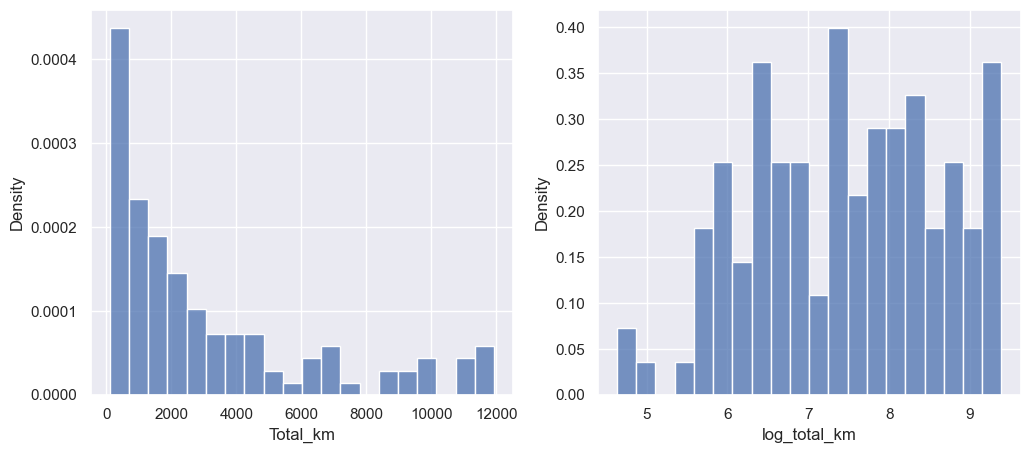

In [31]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

sns.histplot(data=reg_data_no_outlier, x='Total_km',  stat='density', bins = 20, ax = axes[0])

sns.histplot(data=reg_data_no_outlier, x='log_total_km',  stat='density', bins=20, ax=axes[1])
plt.show()

In [32]:
# looking at the distributions, we might want to keep the log transformed version of the total mileage since it looks more 
# "normal" than the original distribution.

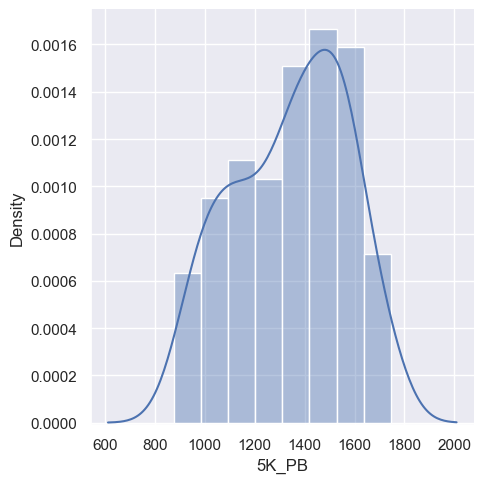

In [33]:
# PDF of the 5K personal records.

sns.displot(reg_data_no_outlier['5K_PB'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.ylim(-0.00001)
plt.show()

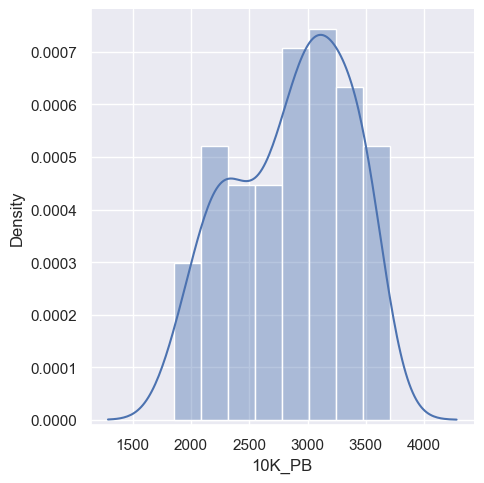

In [34]:
# PDF of the 10K personal records.

sns.displot(reg_data_no_outlier['10K_PB'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.ylim(-0.00001)
plt.show()

In [35]:
# Considering that some observations have been omitted and that their original indexes are preserved, we would
# reset the index to avoid potential problems in the following sections. 

data_cleaned = reg_data_no_outlier.reset_index(drop=True)

In [36]:
data_cleaned.describe(include='all')

,TEMPO_REALE_SECONDS,SESSO,ANNO,2025_km,Total_km,5K_PB,10K_PB,log_total_km
count,116.000000,116,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN
mean,6650.577586,NaN,1987.698276,612.258621,3129.620690,1343.422414,2862.534483,7.462569
std,1184.886728,NaN,10.708160,430.988028,3261.071463,227.462645,489.871508,1.164275
min,4196.000000,NaN,1964.000000,40.000000,103.000000,876.000000,1857.000000,4.634729
25%,5845.000000,NaN,1980.000000,304.250000,678.000000,1146.000000,2466.250000,6.519144
50%,6828.000000,NaN,1989.500000,541.500000,1751.500000,1367.000000,2956.000000,7.467347
75%,7807.000000,NaN,1997.000000,828.250000,4335.500000,1527.000000,3260.000000,8.374580


## Checking the OLS assumptions

### Linearity

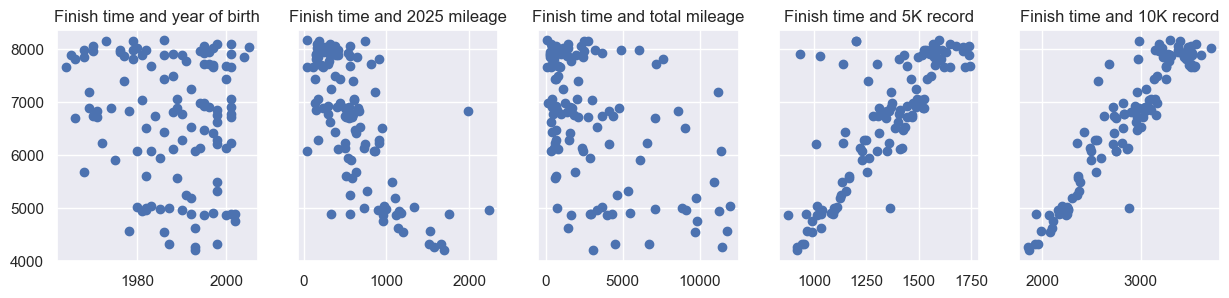

In [39]:
# We would want to plot the regressors vs the dependent variable in order to get a better idea about 
# the relationship between them. 
# Since the finish time is the 'y' axis of all the plots, it would make sense to plot them side-by-side 

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize =(15,3)) #sharey -> share 'TEMPO_REALE_SECONDS' as y
ax1.scatter(data_cleaned['ANNO'],data_cleaned['TEMPO_REALE_SECONDS'])
ax1.set_title('Finish time and year of birth')
ax2.scatter(data_cleaned['2025_km'],data_cleaned['TEMPO_REALE_SECONDS'])
ax2.set_title('Finish time and 2025 mileage')
ax3.scatter(data_cleaned['Total_km'],data_cleaned['TEMPO_REALE_SECONDS'])
ax3.set_title('Finish time and total mileage')
ax4.scatter(data_cleaned['5K_PB'],data_cleaned['TEMPO_REALE_SECONDS'])
ax4.set_title('Finish time and 5K record')
ax5.scatter(data_cleaned['10K_PB'],data_cleaned['TEMPO_REALE_SECONDS'])
ax5.set_title('Finish time and 10K record')

plt.show()

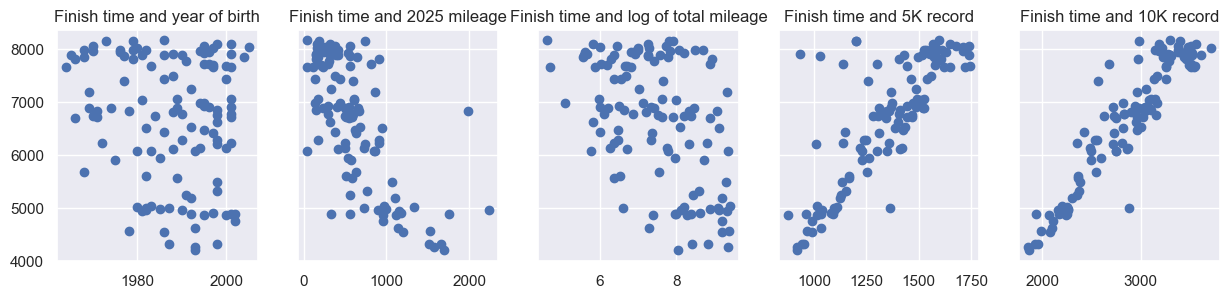

In [40]:
# Considerng the log transformation of the total mileage, let's once again look at the relationship between
# total mileage and half marathon finish time.

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize =(15,3)) #sharey -> share 'TEMPO_REALE_SECONDS' as y
ax1.scatter(data_cleaned['ANNO'],data_cleaned['TEMPO_REALE_SECONDS'])
ax1.set_title('Finish time and year of birth')
ax2.scatter(data_cleaned['2025_km'],data_cleaned['TEMPO_REALE_SECONDS'])
ax2.set_title('Finish time and 2025 mileage')
ax3.scatter(data_cleaned['log_total_km'],data_cleaned['TEMPO_REALE_SECONDS'])
ax3.set_title('Finish time and log of total mileage')
ax4.scatter(data_cleaned['5K_PB'],data_cleaned['TEMPO_REALE_SECONDS'])
ax4.set_title('Finish time and 5K record')
ax5.scatter(data_cleaned['10K_PB'],data_cleaned['TEMPO_REALE_SECONDS'])
ax5.set_title('Finish time and 10K record')

plt.show()

In [41]:
# Considering that the relationship betweeen finish time and log of total mileage visually "seems" somewhat more reasonable
# and it's distribution looks more normal, we will continue the analysis using the log of total mileage as the regressor
# instead of the original values of total_mileage.

data_cleaned = data_cleaned.drop(['Total_km'], axis =1)

### Multicollinearity

In [43]:
data_cleaned.columns.values

array(['TEMPO_REALE_SECONDS', 'SESSO', 'ANNO', '2025_km', '5K_PB',
       '10K_PB', 'log_total_km'], dtype=object)

In [44]:
# We will have to look at the level of dependence among the regressors, i.e., multicollinearity before going forward 
# with the regression analysis. In the case of a VIF around 5 one should start examining the options of omitting the variable
# and looking at the results again.

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data_cleaned[['ANNO', '2025_km', '5K_PB', '10K_PB', 'log_total_km']].copy()

# Add a constant (intercept) column
variables_const = sm.add_constant(variables)

# Compute VIF for each feature
vif = pd.DataFrame()
vif["Features"] = variables_const.columns
vif["VIF"] = [variance_inflation_factor(variables_const.values, i)
              for i in range(variables_const.shape[1])]
vif

,Features,VIF
0,const,48062.942951
1,ANNO,1.291541
2,2025_km,2.668288
3,5K_PB,3.949099
4,10K_PB,4.927181
5,log_total_km,2.348003


In [45]:
# As can be seen from the results of the variance inflation factor analysis above,  the 10k personal bests show 
# a relatively high value of VIF. We will proceed by omitting the 10K_PB and running the VIF analysis a second time. 

variables = data_cleaned[['ANNO', '2025_km', 'log_total_km', '5K_PB']].copy()

# Add a constant (intercept) column
variables_const = sm.add_constant(variables)

# Compute VIF for each feature
vif = pd.DataFrame()
vif["Features"] = variables_const.columns
vif["VIF"] = [variance_inflation_factor(variables_const.values, i)
              for i in range(variables_const.shape[1])]
vif

,Features,VIF
0,const,45776.207983
1,ANNO,1.244253
2,2025_km,2.454464
3,log_total_km,2.243849
4,5K_PB,1.902826


In [46]:
# The results of the VIF looks great and it seems that we can go on with the remaining four regressors, i.e., the year of birth
# mileage in 2025 up until May (Race date was April 27th), the total mileage in their running career (log transformed), and their 5K personal 
#best record. 

data_no_multicollinearity = data_cleaned.drop(['10K_PB'], axis = 1)

### Creating dummy variables

In [48]:
# To include the categorical data in the regression, let's create dummies for sex!

data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first= True)

In [49]:
data_with_dummies.head()

,TEMPO_REALE_SECONDS,ANNO,2025_km,5K_PB,log_total_km,SESSO_M
0,7664.0,1997,40.0,1723.0,5.869297,False
1,8163.0,1986,41.0,1598.0,4.634729,True
2,6080.0,1993,44.0,1299.0,5.768321,True
3,7653.0,2001,109.0,1649.0,4.691348,True
4,6984.0,1995,133.0,1475.0,5.093750,True


In [50]:
# considering this the last point of preprocessing the data, we will store the data in a new variable called
# data_preprocessed

data_preprocessed = data_with_dummies

In [51]:
data_preprocessed['SESSO_M'] = data_preprocessed['SESSO_M'].astype(int)

In [52]:
data_preprocessed.head()

,TEMPO_REALE_SECONDS,ANNO,2025_km,5K_PB,log_total_km,SESSO_M
0,7664.0,1997,40.0,1723.0,5.869297,0
1,8163.0,1986,41.0,1598.0,4.634729,1
2,6080.0,1993,44.0,1299.0,5.768321,1
3,7653.0,2001,109.0,1649.0,4.691348,1
4,6984.0,1995,133.0,1475.0,5.093750,1


## End of Preprocessing

In [54]:
# we will save the preprocessed data to a CSV file to then be used in other models.

data_preprocessed.to_csv("data\\cleaned_half_marathon_data.csv", index=False)

# Linear Regression Model

### Declare inputs and targets

In [57]:
# Defining the inputs, i.e., the regressors and the target, i.e., the dependent variable, which we aim to predit, i.e., 
# finish times.
targets = data_preprocessed['TEMPO_REALE_SECONDS']
inputs = data_preprocessed.drop(['TEMPO_REALE_SECONDS'], axis = 1)

### Scaling the data

In [59]:
# In order for the different weights of the regressors to be comparable, we'd scale all the inputs to homogenize their
# distribution: Normal with a mean of 0 and SD of 1, i.e., z scores.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler()

In [60]:
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [62]:
from sklearn.model_selection import train_test_split 

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365

x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 5)

### Creating the regression

In [64]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [65]:
y_hat = reg.predict(x_train)

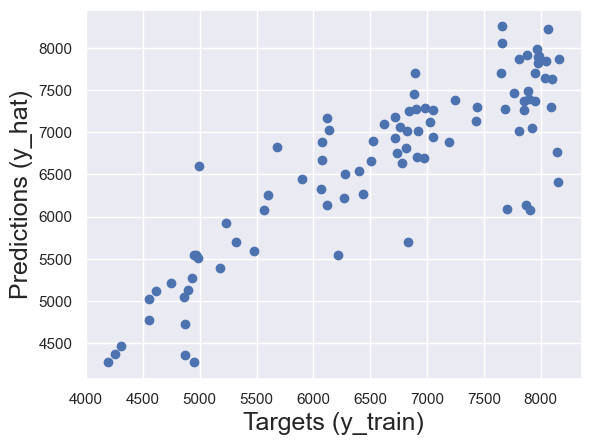

In [66]:
# To compare the targets (y_train) and the predictions (y_hat), we plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.show()

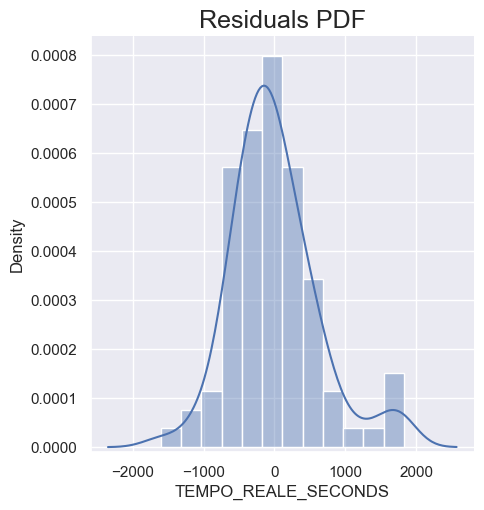

In [67]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.displot(y_train - y_hat,  kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)

plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed

# Given the definition of the residuals (y_train - y_hat), negative values imply
# that y_hat (predictions) are much higher than y_train (the targets)
plt.ylim(-0.00001)
plt.show()

In [68]:
# Find the R-squared of the model both on the test and on the training sets.

print("Train R²:", reg.score(x_train, y_train))
print("Test R²:", reg.score(x_test, y_test))

Train R²: 0.7335063313990686
Test R²: 0.8278708568444483


In [69]:
# It would also make sense to calculate the adjusted r-squared to get a better idea about the regressors
# and how their potential excessive number can penalize the r-squared(on the training data).

r2 = reg.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.718012513457154

In [178]:
# Considering that the value of the adjusted r2 is not hugely different from r2, we may deduce that there are probably not
# too many regressors included in the model.

# At this point, we might want to also look at the cross-validation of the results, by dividing the data into different folds and 
# looking at the average r2 values to get an insight about the generalizability of the model to real data.

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(reg, inputs_scaled, targets, cv=kf, scoring = 'r2')

print('Cross-validated R2 scores:', r2_scores)
print('Mean R2 score:', np.mean(r2_scores))
print('Spread (std) of R2 scores:', np.std(r2_scores))

Cross-validated R2 scores: [0.75241036 0.50957222 0.78751793 0.8092587  0.65155174]
Mean R2 score: 0.7020621892302931
Spread (std) of R2 scores: 0.11039239708700868


In [71]:
# A single 80/20 train/test split yielded an R² of about 0.70, indicating good predictive performance. 
# k-fold (5-fold) cross-validation produced almost the same average R² (~0.7), reflecting more realistic variation 
# in model performance across different subsets of the data. This suggests that the model has predictive value and 
# it is also fairly generalizable.

### Weights and bias

In [73]:
# The interception line!

reg.intercept_

6645.113251729642

In [74]:
# Let's put the data in an organized table.

reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,ANNO,-170.963500
1,2025_km,-390.229038
2,5K_PB,635.933949
3,log_total_km,-21.669795
4,SESSO_M,-117.039725


### Testing

In [76]:
# It is now time to see if the model can perform in an acceptable manner with regard to unseen data, i.e., test data.
# and compare its produced results with the results that we have of those test data.

y_hat_test = reg.predict(x_test)

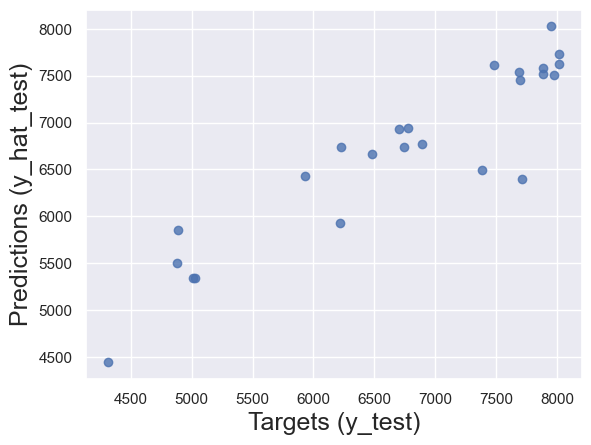

In [77]:
# Create a scatter plot with the test targets and the test predictions. Ideally this would be a 45 degree line
# because we'd hope that our test values match exactly with the predicted values using the model.

plt.scatter(y_test, y_hat_test, alpha=0.8)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)

plt.show()

In [78]:
# Let's create a new dataframe to investigate the performance of the model.

df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf['Target'] = y_test
df_pf

,Prediction,Target
0,8023.989556,NaN
1,7586.301652,NaN
2,5927.584355,NaN
3,7454.151798,NaN
4,7627.081738,NaN
5,7726.390382,NaN
6,5340.580471,7885.0
7,7501.411288,NaN
8,6432.218443,NaN
9,7515.413884,NaN


In [79]:
# We will need to drop the indices of the test data to match them with the predicted values.

y_test = y_test.reset_index(drop=True)

In [80]:
df_pf['Target'] = y_test
df_pf

,Prediction,Target
0,8023.989556,7946.0
1,7586.301652,7882.0
2,5927.584355,6221.0
3,7454.151798,7696.0
4,7627.081738,8015.0
5,7726.390382,8017.0
6,5340.580471,5008.0
7,7501.411288,7977.0
8,6432.218443,5932.0
9,7515.413884,7885.0


In [81]:
# Let's calculate the residuals, i.e., the difference between the predicted and the actual values of finish times.
# plus the difference in the percentage, between them.

df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf

,Prediction,Target,Residual,Difference%
0,8023.99,7946.00,-77.99,0.98
1,7586.30,7882.00,295.70,3.75
2,5927.58,6221.00,293.42,4.72
3,7454.15,7696.00,241.85,3.14
4,7627.08,8015.00,387.92,4.84
5,7726.39,8017.00,290.61,3.62
6,5340.58,5008.00,-332.58,6.64
7,7501.41,7977.00,475.59,5.96
8,6432.22,5932.00,-500.22,8.43
9,7515.41,7885.00,369.59,4.69


In [82]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,24.00,24.00,24.00,24.00
mean,6713.51,6739.92,26.41,5.85
std,926.07,1190.26,493.08,5.03
min,4443.58,4316.00,-969.35,0.03
25%,6279.57,6148.75,-254.96,2.85
50%,6757.20,6833.50,-37.88,4.22
75%,7521.48,7756.75,293.99,7.03
max,8023.99,8017.00,1318.10,19.83


In [83]:
# We can see that on average, there's a ~ 5.85 percent difference, meaning that our model on average is 5.85 percent off
# when predicting the half-marathon finish times. It is noteworthy that 75 percent of all of these predictions are less than 7
# percent off, with half of them being accurate almost at a 4 percent margin.

In [84]:
# Considering the acceptable performance of the model, let's now interpret the weights of the predictors.

reg_summary

,Features,Weights
0,ANNO,-170.96
1,2025_km,-390.23
2,5K_PB,635.93
3,log_total_km,-21.67
4,SESSO_M,-117.04


In [85]:
 # Considering that all the regressors were scaled, the weights calculated here mean that for every change of 1 standard deviation in a regressor
# the predicted half marathon time increases by the value of the weight, if other variables were held constant.
# So, we will be needing the SDs of the regressors to make interpretations.

In [86]:
# Based on the tables above, we can conclude that, 5K personal bests are actually the best predictors of half-marathon 
# finish times. For every 227 seconds of better performance in the 5K you get a 636 seconds of better time in half-marathon, roughly speaking
# if you increase your 5K times by 4 minutes  you can hope for 10 minutes better performance in the half-marathon.

# At the second post is the total kilometers covered in the last 4 months before the race, i.e., 2025_km. Considering that the SD of 2025 is 430, 
# everything held constant, if you added 430 km to your running routine in the last 4 months before the race, 
# you could have expected a 390 seconds decrease in your finish times.

# Year of birth is the third strongest predictor, showing that for every 10 years of being younger, one was able to finish the race
# 170 seconds faster!

# Since the log scale is involved, an increase of 1.16 in log_total_km corresponds to multiplying total km by ~3.2× (because e^1.16 ≈ 3.2).
# So almost tripling total training kilometers is associated with running the half marathon ~22 seconds faster, on average, all else equal.

In [87]:
data_preprocessed.groupby('SESSO_M')['TEMPO_REALE_SECONDS'].mean()

SESSO_M
0   6997.48
1   6422.61
Name: TEMPO_REALE_SECONDS, dtype: float64

In [88]:
# In the end, being a male makes you 575 seconds faster on average, everthing else held constant!

In [89]:
# We started with a basic linear model, it would make sense to test regularized versions to improve generalization and interpretability.
# Ridge and Lasso are extensions of standard linear regression.

# In both Ridge and Lasso regression, alpha is the regularization strength parameter. It controls how much penalty is applied to the model's 
# coefficients to prevent overfitting.

from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha = 1)
ridge.fit(x_train, y_train)
ridge_preds = ridge.predict(x_test)

lasso = Lasso(alpha = 0.1)
lasso.fit(x_train, y_train)
lasso_preds = lasso.predict(x_test)


In [90]:
# Here we will be calculating the R2 of the regularized versions of the simple linear regression and compare it with
# that of the simple linear regression.

from sklearn.metrics import r2_score

print("Ridge R2:", r2_score(y_test, ridge_preds))
print("Lasso R2:", r2_score(y_test, lasso_preds))
print("Simple regression R2:", r2_score(y_test, reg.predict(x_test)))

Ridge R2: 0.8271646099547654
Lasso R2: 0.8278017278375249
Simple regression R2: 0.8278708568444483


In [91]:
# let's organize the R2 of test and training data drawn from the three models in a table to summarize the 
# findings.

train_scores = {
    'Linear': reg.score(x_train, y_train),
    'Ridge': ridge.score(x_train, y_train),
    'Lasso': lasso.score(x_train, y_train)
}
test_scores = {
    'Linear': reg.score(x_test, y_test),
    'Ridge': ridge.score(x_test, y_test),
    'Lasso': lasso.score(x_test, y_test)
}

r2_df = pd.DataFrame({
    'Train R²': train_scores,
    'Test R²': test_scores
})

r2_df.round(3)

,Train R²,Test R²
Linear,0.73,0.83
Ridge,0.73,0.83
Lasso,0.73,0.83


In [92]:
# Organizing the weights obtained by the three models in a separate table.

w_df = pd.DataFrame({"Feature": inputs.columns, "Linear": reg.coef_, "Ridge": ridge.coef_, "Lasso": lasso.coef_})
w_df

,Feature,Linear,Ridge,Lasso
0,ANNO,-170.96,-170.87,-170.82
1,2025_km,-390.23,-387.75,-390.23
2,5K_PB,635.93,628.23,635.93
3,log_total_km,-21.67,-26.94,-21.52
4,SESSO_M,-117.04,-117.63,-116.94


In [93]:
# Looking at the performance of the ridge regularization on the test data.

ridge_pf = pd.DataFrame(ridge.predict(x_test), columns=['Prediction'])
ridge_pf['Target'] = y_test
ridge_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
ridge_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
ridge_pf.describe()

,Prediction,Target,Residual,Difference%
count,24.00,24.00,24.00,24.00
mean,6712.57,6739.92,26.41,5.85
std,920.44,1190.26,493.08,5.03
min,4455.33,4316.00,-969.35,0.03
25%,6289.22,6148.75,-254.96,2.85
50%,6756.83,6833.50,-37.88,4.22
75%,7518.27,7756.75,293.99,7.03
max,8016.15,8017.00,1318.10,19.83


In [94]:
# Looking at the performance of the lasso regularization on the test data.

lasso_pf = pd.DataFrame(lasso.predict(x_test), columns=['Prediction'])
lasso_pf['Target'] = y_test
lasso_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
lasso_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
lasso_pf.describe()

,Prediction,Target,Residual,Difference%
count,24.00,24.00,24.00,24.00
mean,6713.51,6739.92,26.41,5.85
std,925.91,1190.26,493.08,5.03
min,4443.98,4316.00,-969.35,0.03
25%,6279.44,6148.75,-254.96,2.85
50%,6757.21,6833.50,-37.88,4.22
75%,7521.38,7756.75,293.99,7.03
max,8023.62,8017.00,1318.10,19.83


In [95]:
# interestingly we see that the three models perform very similarly on the test dataset which can mean that
# the original linear regression model was stable and the data isn’t overly noisy or high-dimensional, 
# so regularization (Ridge/Lasso) could not improve generalization that much.

#The simple Linear Regression is not overfitting, so Ridge/Lasso’s regularization isn’t providing significant gains.

#Your input features might not be collinear or overly complex, so even the vanilla model is doing well.

# altogether, looking at the train and test R2 values, weights, and the average error of prediction,
# the ridge/lasso regularization does not contribute significantly to the results, thus
# we would go forward with the results of the simple linear regression as the predictor.


In [96]:
# we will save the regression model and the scaler in a file to be used later in the predictor function.

import joblib

joblib.dump(reg, 'regression_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']